In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


import sys
sys.path.append("..")
from utils_image import compute_zpos_sp, get_meanZstack
from utils_analysis import plot_trajectory, getTuningMap, getTuningMap_shuffle
from utils_fluorescence import get_deltaF_F_and_fr
from scanimagetiffio import SITiffIO

### 0, set path

In [19]:
# zstack_folder = "/media/zilong/4TB Storage HDD/2PImaging/183_06082023_largezstack/"
# zstack_tiff_name = 'stack06082023_00001.tif'
# zstack_RE_logfile = 'REdata_20230806_141637.stack00001.txt'

# superficial_folder = "/media/zilong/4TB Storage HDD/2PImaging/183_06082023_superficial"
# superf_namelist = ["00003", "00005", "00008", "00009", "00012", "00013", "00016", "00017"]

# deep_folder = "/media/zilong/4TB Storage HDD/2PImaging/183_06082023_deep"
# deep_namelist = ["00006", "00007", "00010", "00011", "00014", "00015", "00018", "00019", "00020"]


zstack_folder = "/media/zilong/4TB Storage HDD/2PImaging/184_06082023_largezstack/"
zstack_tiff_name = 'stack06082023_00025.tif'
zstack_RE_logfile = 'REdata_20230806_194853.stack00025.txt'

superficial_folder = "/media/zilong/4TB Storage HDD/2PImaging/184_06082023_superficial"
superf_namelist = ["000015", "00016", "00017", "00018", "00019", "00020", "00021", "00022", "00023"]

deep_folder = "/media/zilong/4TB Storage HDD/2PImaging/184_06082023_deep"
deep_namelist = ["00006", "00007", "00008", "00009", "00010", "00011", "00012", "00013", "00014"]

### 1, Get the correlation of the superficial and deep layers with zstacks

In [20]:
#get meanzstacks

#if meanZstack.npy already exists, then load it
if os.path.exists(os.path.join(zstack_folder, "DP_exp/meanstacks.npy")):
    meanstacks = np.load(os.path.join(zstack_folder, "DP_exp/meanstacks.npy"))
else:
    # read the rotation center from the circlecenter txt file
    circlecenterfilename = zstack_folder+"DP_exp/circlecenter.txt"
    with open(circlecenterfilename, "r") as f:
        # read the last row
        last_line = f.readlines()[-1]
        # assign the x and y coordinates to self.rotx and self.roty
        rotx = float(last_line.split()[0])
        roty = float(last_line.split()[1])
    print("Rotation center is at ({}, {})".format(rotx, roty))

    tiffpath = os.path.join(zstack_folder, zstack_tiff_name)
    logpath = os.path.join(zstack_folder, zstack_RE_logfile)
    volume = 1; stacks=81; frames=200; Rotcenter=[rotx, roty]; ImgReg=True

    S = SITiffIO()
    S.open_tiff_file(tiffpath, "r")
    S.open_rotary_file(logpath)
    S.interp_times() 
    meanstacks = get_meanZstack(S, volume, stacks, frames, Rotcenter, ImgReg)

    #save the meanZ stack as npy file
    np.save(os.path.join(zstack_folder, "DP_exp/meanstacks.npy"), meanstacks)


1 planes, 0/1 frames, 0.09 sec.
11 planes, 0/1 frames, 0.33 sec.
21 planes, 0/1 frames, 0.66 sec.
31 planes, 0/1 frames, 0.93 sec.
41 planes, 0/1 frames, 1.26 sec.
51 planes, 0/1 frames, 1.61 sec.
61 planes, 0/1 frames, 1.97 sec.
71 planes, 0/1 frames, 2.30 sec.
80 planes, 0/1 frames, 2.53 sec.
1 planes, 0/1 frames, 0.10 sec.
11 planes, 0/1 frames, 0.38 sec.
21 planes, 0/1 frames, 0.77 sec.
31 planes, 0/1 frames, 1.02 sec.
41 planes, 0/1 frames, 1.28 sec.
51 planes, 0/1 frames, 1.52 sec.
61 planes, 0/1 frames, 1.77 sec.
71 planes, 0/1 frames, 2.03 sec.
80 planes, 0/1 frames, 2.30 sec.


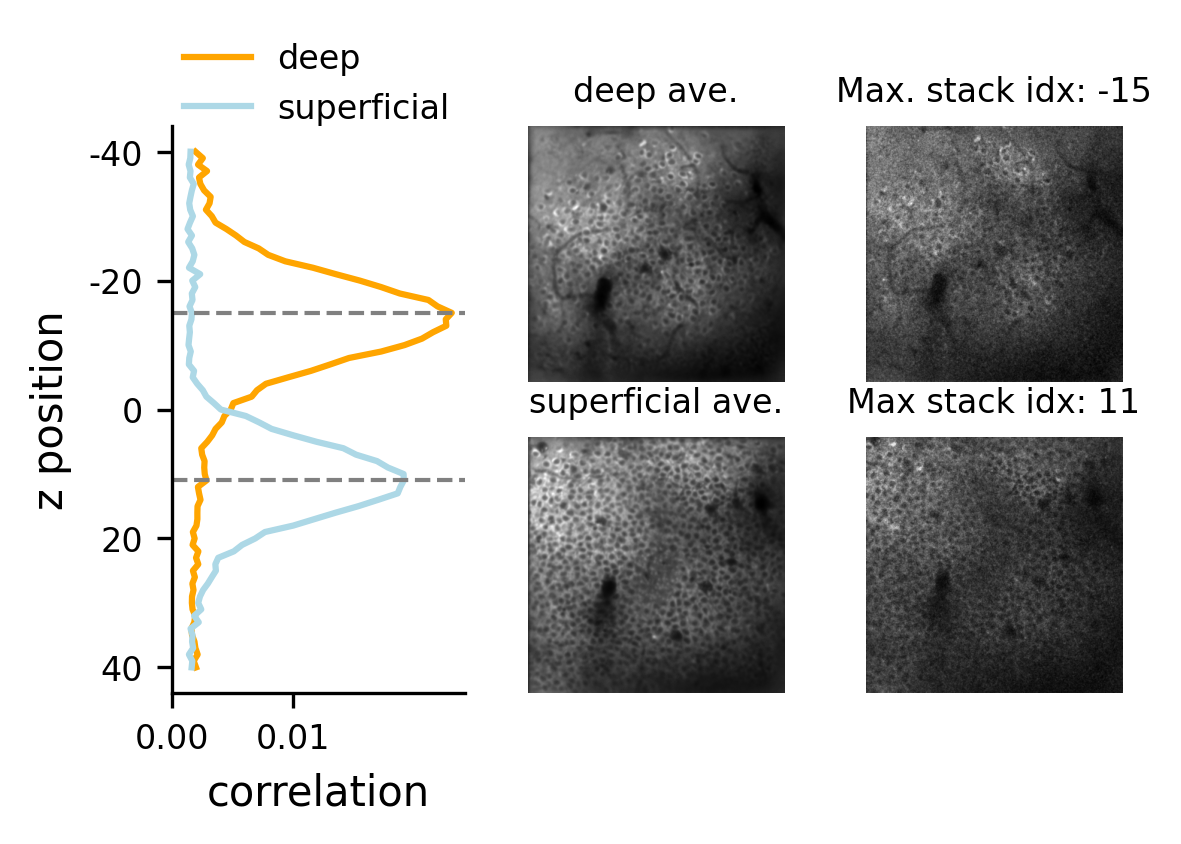

In [21]:
#load meanImage from superficial layer

#load ops
ops =  np.load(os.path.join(superficial_folder, 'UnrotTiff/suite2p/plane0', 'ops.npy'), allow_pickle=True)
ops = ops.item()
superf_meanIm = ops['meanImg']

#transpose superf_meanIm
superf_meanIm = superf_meanIm.T
#add a axis on dim 0 of superf_meanIm
superf_meanIm = np.expand_dims(superf_meanIm, axis=0)
_, _, corrMatrix_superf = compute_zpos_sp(meanstacks, superf_meanIm, ops)


#load meanImage from deep layer

#load ops
ops =  np.load(os.path.join(deep_folder, 'UnrotTiff/suite2p/plane0', 'ops.npy'), allow_pickle=True)
ops = ops.item()
deep_meanIm = ops['meanImg']
#transpose deep_meanIm
deep_meanIm = deep_meanIm.T
#add a axis on dim 0 of deep_meanIm
deep_meanIm = np.expand_dims(deep_meanIm, axis=0)
_, _, corrMatrix_deep = compute_zpos_sp(meanstacks, deep_meanIm, ops)

#plot the two correlation matrix with different color

#imshow the averaged image
fig = plt.figure(figsize=(4,3), dpi=300)

labelsize = 10
ticksize = 8
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

##########################################################################################
ax1 = fig.add_subplot(gs[:, 0])
#plot the correlation matrix
ax1.plot(corrMatrix_superf, np.arange(0, len(corrMatrix_superf)), color='orange', label='deep')
ax1.plot(corrMatrix_deep, np.arange(0, len(corrMatrix_deep)), color='lightblue', label='superficial')
#flip y axis
ax1.invert_yaxis()
#show legend at the bottom without box, move it lower a bit
ax1.legend(loc='upper right', fontsize=ticksize, frameon=False, bbox_to_anchor=(1.05, 1.2))
#label
ax1.set_ylabel('z position', fontsize=labelsize)
ax1.set_xlabel('correlation', fontsize=labelsize)
#set xticks from 0 to 0.01
ax1.set_xticks([0, 0.01])
#change y ticks from 0 41, 80 to -40, 0, 40
ax1.set_yticks([0, 20, 40, 60, 80])
ax1.set_yticklabels([-40, -20, 0, 20, 40], fontsize=ticksize)
#set x ticks size to ticksize
ax1.tick_params(axis='x', labelsize=ticksize)
#set top and right axis invisible
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

##########################################################################################
#plot the averaged image of superficial layer
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(superf_meanIm[0,:,:], cmap='gray')
ax2.set_xticks([]); ax2.set_yticks([])
ax2.axis('off')
#title
ax2.set_title('deep ave.', fontsize=ticksize)

##########################################################################################
#plot the averaged image of deep layer
ax3 = fig.add_subplot(gs[1, 1])
ax3.imshow(deep_meanIm[0,:,:], cmap='gray')
ax3.set_xticks([]); ax3.set_yticks([])
ax3.axis('off')
ax3.set_title('superficial ave.', fontsize=ticksize)

##########################################################################################
ax4 = fig.add_subplot(gs[0, 2])
#plot the corresponding z stack image of superficial layer
#find the maximum correlation index of superficial layer in corrMatrix_superf
max_corr_index_superf = np.argmax(corrMatrix_superf)
ax4.imshow(meanstacks[max_corr_index_superf,:,:], cmap='gray')
ax4.set_xticks([]); ax4.set_yticks([])
ax4.axis('off')
ax4.set_title('Max. stack idx: {}'.format(max_corr_index_superf-40), fontsize=ticksize)

##########################################################################################
ax5 = fig.add_subplot(gs[1, 2])
#plot the corresponding z stack image of deep layer
#find the maximum correlation index of deep layer in corrMatrix_deep
max_corr_index_deep = np.argmax(corrMatrix_deep)
ax5.imshow(meanstacks[max_corr_index_deep,:,:], cmap='gray')
ax5.set_xticks([]); ax5.set_yticks([])
ax5.axis('off')
ax5.set_title('Max stack idx: {}'.format(max_corr_index_deep-40), fontsize=ticksize)

#mark the two max correlation index on ax1 with grey lines
ax1.axhline(y=max_corr_index_superf, color='grey', linestyle='--', linewidth=1)
ax1.axhline(y=max_corr_index_deep, color='grey', linestyle='--', linewidth=1)
    

plt.tight_layout()

#save 
savefolder = os.path.join(superficial_folder, 'UnrotTiff', '2D2P')

plt.savefig(os.path.join(savefolder, 'superficial_vs_deep_correlation.png'), dpi=300, bbox_inches='tight')

### 2, get all the tuning maps for the superficial layer

In [5]:
#get the trajectory of superficial layer

#superf_namelist = ["00003", "00005", "00008", "00009", "00012", "00013", "00016", "00017"]

#if trajectory is already saved in pickle file, load it
if os.path.exists(os.path.join(superficial_folder,'UnrotTiff', '2D2P','trajectory.pickle')):
    with open(os.path.join(superficial_folder,'UnrotTiff', '2D2P','trajectory.pickle'), 'rb') as f:
        trajectory = pickle.load(f)
    allX_sf = trajectory[0]
    allZ_sf = trajectory[1]
    allTime_sf = trajectory[2]
    allTheta_sf = trajectory[3]
else:
    allX_sf, allZ_sf, allTime_sf, allTheta_sf, fig_sf = plot_trajectory(superficial_folder, superf_namelist)

#chnage allX and allZ from dictionary to np.array
Traj_x_sf = np.concatenate(list(allX_sf.values()))
Traj_z_sf = np.concatenate(list(allZ_sf.values()))
minx_sf = np.min(Traj_x_sf); maxx_sf = np.max(Traj_x_sf)
minz_sf = np.min(Traj_z_sf); maxz_sf = np.max(Traj_z_sf)
#normalize x and z to [0,1]
Traj_x_sf = (Traj_x_sf-minx_sf)/(maxx_sf-minx_sf)
Traj_z_sf = (Traj_z_sf-minz_sf)/(maxz_sf-minz_sf)

#concatenate the time stamps, a
# add 0.033 + the last element to make sure the time stamps at each boundary are not the same using for loop
for i in range(len(allTime_sf)):
    #chnage allTime[i] to np.array
    allTime_sf[i] = np.array(allTime_sf[i])
    if i == 0:
        timestamps_sf = allTime_sf[i]
    else:
        timestamps_sf = np.concatenate((timestamps_sf, allTime_sf[i]+timestamps_sf[-1]+0.033))

In [6]:
processed_datafolder = os.path.join(superficial_folder, 'UnrotTiff/suite2p/plane0')

#load the processed data
spks = np.load(os.path.join(processed_datafolder, 'spks.npy'), allow_pickle=True)
#load raw fluorescence signal F and neuropil signal Fneu
F = np.load(os.path.join(processed_datafolder, 'F.npy'), allow_pickle=True)
Fneu = np.load(os.path.join(processed_datafolder, 'Fneu.npy'), allow_pickle=True)
#get the neuropil corrected signal Fcorr = F-0.7*Fneu
Fcorr = F - 0.7*Fneu

stats = np.load(os.path.join(processed_datafolder, 'stat.npy'), allow_pickle=True)
ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops = ops.item()
iscell = np.load(os.path.join(processed_datafolder, 'iscell.npy'), allow_pickle=True)


#get the deltaF/F and firing rate from deconvolved calcium traces and neuropil corrected signal, if not exist, calculate it
if os.path.exists(os.path.join(processed_datafolder, 'deltaF.npy')) and os.path.exists(os.path.join(processed_datafolder, 'fr.npy')):
    deltaF = np.load(os.path.join(processed_datafolder, 'deltaF.npy'))
    fr = np.load(os.path.join(processed_datafolder, 'fr.npy'))
else:
    deltaF, fr = get_deltaF_F_and_fr(spks, Fcorr, moving_window=15, framerate=30, percetile=8)
    #save deltaF and fr to processed_datafolder as npy file
    np.save(os.path.join(processed_datafolder, 'deltaF.npy'), deltaF)
    np.save(os.path.join(processed_datafolder, 'fr.npy'), fr)

Text(0.5, 1.0, 'Peak=92.30')

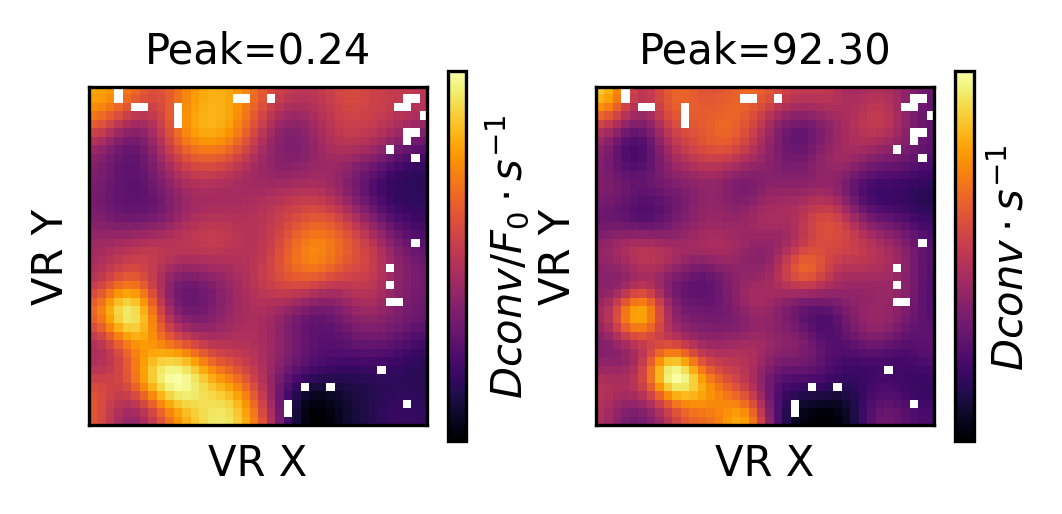

In [7]:
ind=12
map = getTuningMap(fr[ind], Traj_x_sf, Traj_z_sf, timestamps_sf, VRsize=(1,1), 
                   binsize=(0.025,0.025), sigma=5/2.5, speed_thres=0.025, 
                   boxcar_size=5, visit_thres=0.1,
                   cell_id=ind, datafolder=superficial_folder)

map2 = getTuningMap(spks[ind], Traj_x_sf, Traj_z_sf, timestamps_sf, VRsize=(1,1), 
                   binsize=(0.025,0.025), sigma=5/2.5, speed_thres=0.025, 
                   boxcar_size=5, visit_thres=0.1,
                   cell_id=ind, datafolder=superficial_folder)

plt.figure(figsize=(4, 2), dpi=300)
labelsize = 10
ticksize = 8
plt.subplot(1,2,1)
#imshow the map
plt.imshow(map, cmap='inferno')
#axis off
#plt.axis('off')
#xlabel and ylabel
plt.xlabel('VR X', fontsize=labelsize)
plt.ylabel('VR Y', fontsize=labelsize)
# #set xticks and yticks from 0 to map.shape[0], but relabel them as 0 to 1
# plt.xticks(np.linspace(0, map.shape[0], 5), np.linspace(0, 1, 5), fontsize=ticksize)
# plt.yticks(np.linspace(0, map.shape[1], 5), np.linspace(0, 1, 5), fontsize=ticksize)
plt.xticks([]); plt.yticks([])
#add colorbar and label in a latex format Dconv/F_0 /dot s^-1
cbar = plt.colorbar(label='$Dconv/F_0 \cdot s^{-1}$', shrink=0.8)
#remove colorbar ticks
cbar.set_ticks([])
#set tick labels size as ticksize
cbar.ax.tick_params(labelsize=labelsize)
#add peak value as text at the right top corner of the map, do not overlap with the map
#plt.text(0.5, 1.05, 'Peak={:.2f}'.format(np.nanmax(map)), fontsize=labelsize, transform=plt.gca().transAxes)
plt.title('Peak={:.2f}'.format(np.nanmax(map)), fontsize=labelsize)

plt.subplot(1,2,2)
#imshow the map
plt.imshow(map2, cmap='inferno')
#axis off
#plt.axis('off')
#xlabel and ylabel
plt.xlabel('VR X', fontsize=labelsize)
plt.ylabel('VR Y', fontsize=labelsize)
# #set xticks and yticks from 0 to map.shape[0], but relabel them as 0 to 1
# plt.xticks(np.linspace(0, map.shape[0], 5), np.linspace(0, 1, 5), fontsize=ticksize)
# plt.yticks(np.linspace(0, map.shape[1], 5), np.linspace(0, 1, 5), fontsize=ticksize)
plt.xticks([]); plt.yticks([])
#add colorbar and label in a latex format Dconv/F_0 /dot s^-1
cbar = plt.colorbar(label='$Dconv \cdot s^{-1}$', shrink=0.8)
#remove colorbar ticks
cbar.set_ticks([])
#set tick labels size as ticksize
cbar.ax.tick_params(labelsize=labelsize)
#add peak value as text at the right top corner of the map, do not overlap with the map
#plt.text(0.5, 1.05, 'Peak={:.2f}'.format(np.nanmax(map)), fontsize=labelsize, transform=plt.gca().transAxes)
plt.title('Peak={:.2f}'.format(np.nanmax(map2)), fontsize=labelsize)

In [8]:
#get the index
cell_idx = np.where(iscell[:,0]==1)[0]
peak_thres = 0.15
peak_up_thres = 100
N=200 #shuffle 200 times

#for each neuron, calculate the tuning map
potentialPC_maps = {}
peaks = {}
SIC_real_all = {}
SIC_shuffle_all = {}

for i, key in enumerate(cell_idx):
    print('Getting tuning map of cell '+str(key))
    
    map = getTuningMap(fr[key], Traj_x_sf, Traj_z_sf, timestamps_sf, 
                       VRsize=(1,1), binsize=(0.025,0.025), sigma=3, 
                       speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                       peak_thres=peak_thres, cell_id=key, datafolder=superficial_folder)
    
    peaks[key] = np.nanmax(map)
    
    #filter out the maps with peak value less than peak_thres
    if np.nanmax(map)<peak_thres or np.nanmax(map)>peak_up_thres:
        continue
    
    ############################################################################################################
    #then filter the maps with SIC exceeding 95 percentile of the shuffled map
    #calculate spatial information content of each map in valid_maps
    #spatial information content is calculated as 
    #       sum_i(p_i*\lambda_i/\lambda)log_2(\lambda_i/\lambda)
    #where \lambda_i is the calcium activity in the i-th bin, which is ave_calcium_in_bin_devided_by_counts
    #      \lambda is the mean calcium activity across all bins, which is all_calcium_mean
    #      p_i is the probablity of the mouse visiting the i-th bin, which is prob_visit

    print('Calculating spatial information content of cell '+str(key))
    results = getTuningMap(fr[key], Traj_x_sf, Traj_z_sf, timestamps_sf, VRsize=(1,1),
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None, return_all=True,
                        apply_adaptive_binning=True)
    
    _, ave_calcium_in_bin_raw, all_calcium_mean, prob_visit, _, _, _ = results
    #calculate the spatial information content
    SICMat_real = prob_visit*ave_calcium_in_bin_raw/all_calcium_mean*np.log2(ave_calcium_in_bin_raw/all_calcium_mean+1e-10)
    SIC_real = np.nansum(SICMat_real)

    #shuffle fr[key] by rolling it with a random number between 0 and 1000
    #and calculate the spatial information content of the shuffled data
    #do this N times
    fr_shuffle = np.zeros((N, len(fr[key])))
    for j in range(N):
        fr_shuffle[j] = np.roll(fr[key], np.random.randint(1800, len(fr[key])-1800))
        
    results = getTuningMap_shuffle(fr_shuffle, Traj_x_sf, Traj_z_sf, timestamps_sf, VRsize=(1,1),
                    binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                    apply_adaptive_binning=True)
    ave_calcium_in_bin_shuffle, all_calcium_mean_shuffle, prob_visit_shuffle, _, _, _ = results
    #calculate the spatial information content for shuffled data
    
    SICMat_shuffle = np.zeros((N, len(prob_visit), len(prob_visit))) 
    for j in range(N):
        SICMat_shuffle[j] = prob_visit_shuffle[j,:,:]*ave_calcium_in_bin_shuffle[j,:,:]/all_calcium_mean_shuffle[j]*np.log2(ave_calcium_in_bin_shuffle[j,:,:]/all_calcium_mean_shuffle[j]+1e-10)

    SIC_shuffle = np.nansum(SICMat_shuffle, axis=(1,2))

    #for each elemnt in SI_real_all, if it exist 95% percentile in SI_shuffle_all, then select the correpsonding neuron in valid_maps
    #save them to potentialPC_maps with the key as the neuron index and value as the map
    if SIC_real > np.percentile(SIC_shuffle, 75):
        potentialPC_maps[key] = map
        SIC_real_all[key] = SIC_real
        SIC_shuffle_all[key] = SIC_shuffle

#save SIC_real_all, SIC_shuffle_all, and potentialPC_maps into one pickle file in savefolder
savefolder = os.path.join(superficial_folder, 'UnrotTiff', '2D2P')
Potential_PC_results = {'decov_F_peaks': peaks, 'SIC_real_all':SIC_real_all, 'SIC_shuffle_all':SIC_shuffle_all, 'potentialPC_maps':potentialPC_maps}
with open(os.path.join(savefolder, 'Potential_PC_results.pickle'), 'wb') as f:
    pickle.dump(Potential_PC_results, f)

Getting tuning map of cell 1
Calculating spatial information content of cell 1
Getting tuning map of cell 2
Calculating spatial information content of cell 2
Getting tuning map of cell 3
Calculating spatial information content of cell 3
Getting tuning map of cell 4
Calculating spatial information content of cell 4
Getting tuning map of cell 5
Calculating spatial information content of cell 5
Getting tuning map of cell 6
Calculating spatial information content of cell 6
Getting tuning map of cell 7
Calculating spatial information content of cell 7
Getting tuning map of cell 8
Calculating spatial information content of cell 8
Getting tuning map of cell 9
Calculating spatial information content of cell 9
Getting tuning map of cell 10
Calculating spatial information content of cell 10
Getting tuning map of cell 11
Calculating spatial information content of cell 11
Getting tuning map of cell 12
Calculating spatial information content of cell 12
Getting tuning map of cell 13
Calculating spat

In [10]:
len(Potential_PC_results['potentialPC_maps'])

98

### 3, get all the tuning maps for the deep layer

In [11]:
#get the trajectory of deep layer

#deep_namelist = ["00006", "00007", "00010", "00011", "00014", "00015", "00018", "00019", "00020"]

#if trajectory is already saved in pickle file, load it
if os.path.exists(os.path.join(deep_folder,'UnrotTiff', '2D2P','trajectory.pickle')):
    with open(os.path.join(deep_folder,'UnrotTiff', '2D2P','trajectory.pickle'), 'rb') as f:
        trajectory = pickle.load(f)
    allX_dp = trajectory[0]
    allZ_dp = trajectory[1]
    allTime_dp = trajectory[2]
    allTheta_dp = trajectory[3]
else:
    allX_dp, allZ_dp, allTime_dp, allTheta_dp, fig_dp = plot_trajectory(deep_folder, deep_namelist)

#chnage allX and allZ from dictionary to np.array
Traj_x_dp = np.concatenate(list(allX_dp.values()))
Traj_z_dp = np.concatenate(list(allZ_dp.values()))
minx_dp = np.min(Traj_x_dp); maxx_dp = np.max(Traj_x_dp)
minz_dp = np.min(Traj_z_dp); maxz_dp = np.max(Traj_z_dp)
#normalize x and z to [0,1]
Traj_x_dp = (Traj_x_dp-minx_dp)/(maxx_dp-minx_dp)
Traj_z_dp = (Traj_z_dp-minz_dp)/(maxz_dp-minz_dp)

#concatenate the time stamps, a
# add 0.033 + the last element to make sure the time stamps at each boundary are not the same using for loop
for i in range(len(allTime_dp)):
    #chnage allTime[i] to np.array
    allTime_dp[i] = np.array(allTime_dp[i])
    if i == 0:
        timestamps_dp = allTime_dp[i]
    else:
        timestamps_dp = np.concatenate((timestamps_dp, allTime_dp[i]+timestamps_dp[-1]+0.033))

In [12]:
processed_datafolder = os.path.join(deep_folder, 'UnrotTiff/suite2p/plane0')

#load the processed data
spks = np.load(os.path.join(processed_datafolder, 'spks.npy'), allow_pickle=True)
#load raw fluorescence signal F and neuropil signal Fneu
F = np.load(os.path.join(processed_datafolder, 'F.npy'), allow_pickle=True)
Fneu = np.load(os.path.join(processed_datafolder, 'Fneu.npy'), allow_pickle=True)
#get the neuropil corrected signal Fcorr = F-0.7*Fneu
Fcorr = F - 0.7*Fneu

stats = np.load(os.path.join(processed_datafolder, 'stat.npy'), allow_pickle=True)
ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops = ops.item()
iscell = np.load(os.path.join(processed_datafolder, 'iscell.npy'), allow_pickle=True)


#get the deltaF/F and firing rate from deconvolved calcium traces and neuropil corrected signal, if not exist, calculate it
if os.path.exists(os.path.join(processed_datafolder, 'deltaF.npy')) and os.path.exists(os.path.join(processed_datafolder, 'fr.npy')):
    deltaF = np.load(os.path.join(processed_datafolder, 'deltaF.npy'))
    fr = np.load(os.path.join(processed_datafolder, 'fr.npy'))
else:
    deltaF, fr = get_deltaF_F_and_fr(spks, Fcorr, moving_window=15, framerate=30, percetile=8)
    #save deltaF and fr to processed_datafolder as npy file
    np.save(os.path.join(processed_datafolder, 'deltaF.npy'), deltaF)
    np.save(os.path.join(processed_datafolder, 'fr.npy'), fr)

In [13]:
#get the index
cell_idx = np.where(iscell[:,0]==1)[0]
peak_thres = 0.15
peak_up_thres = 100
N=200 #shuffle 200 times

#for each neuron, calculate the tuning map
potentialPC_maps = {}
peaks = {}
SIC_real_all = {}
SIC_shuffle_all = {}

for i, key in enumerate(cell_idx):
    print('Getting tuning map of cell '+str(key))
    
    map = getTuningMap(fr[key], Traj_x_dp, Traj_z_dp, timestamps_dp, 
                       VRsize=(1,1), binsize=(0.025,0.025), sigma=3, 
                       speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                       peak_thres=peak_thres, cell_id=key, datafolder=deep_folder)
    
    peaks[key] = np.nanmax(map)
    
    #filter out the maps with peak value less than peak_thres
    if np.nanmax(map)<peak_thres or np.nanmax(map)>peak_up_thres:
        continue
    
    ############################################################################################################
    #then filter the maps with SIC exceeding 95 percentile of the shuffled map
    #calculate spatial information content of each map in valid_maps
    #spatial information content is calculated as 
    #       sum_i(p_i*\lambda_i/\lambda)log_2(\lambda_i/\lambda)
    #where \lambda_i is the calcium activity in the i-th bin, which is ave_calcium_in_bin_devided_by_counts
    #      \lambda is the mean calcium activity across all bins, which is all_calcium_mean
    #      p_i is the probablity of the mouse visiting the i-th bin, which is prob_visit

    print('Calculating spatial information content of cell '+str(key))
    results = getTuningMap(fr[key], Traj_x_dp, Traj_z_dp, timestamps_dp, VRsize=(1,1),
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None, return_all=True,
                        apply_adaptive_binning=True)
    
    _, ave_calcium_in_bin_raw, all_calcium_mean, prob_visit, _, _, _ = results
    #calculate the spatial information content
    SICMat_real = prob_visit*ave_calcium_in_bin_raw/all_calcium_mean*np.log2(ave_calcium_in_bin_raw/all_calcium_mean+1e-10)
    SIC_real = np.nansum(SICMat_real)

    #shuffle fr[key] by rolling it with a random number between 0 and 1000
    #and calculate the spatial information content of the shuffled data
    #do this N times
    fr_shuffle = np.zeros((N, len(fr[key])))
    for j in range(N):
        fr_shuffle[j] = np.roll(fr[key], np.random.randint(1800, len(fr[key])-1800))
        
    results = getTuningMap_shuffle(fr_shuffle, Traj_x_dp, Traj_z_dp, timestamps_dp, VRsize=(1,1),
                    binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                    apply_adaptive_binning=True)
    ave_calcium_in_bin_shuffle, all_calcium_mean_shuffle, prob_visit_shuffle, _, _, _ = results
    #calculate the spatial information content for shuffled data
    
    SICMat_shuffle = np.zeros((N, len(prob_visit), len(prob_visit))) 
    for j in range(N):
        SICMat_shuffle[j] = prob_visit_shuffle[j,:,:]*ave_calcium_in_bin_shuffle[j,:,:]/all_calcium_mean_shuffle[j]*np.log2(ave_calcium_in_bin_shuffle[j,:,:]/all_calcium_mean_shuffle[j]+1e-10)

    SIC_shuffle = np.nansum(SICMat_shuffle, axis=(1,2))

    #for each elemnt in SI_real_all, if it exist 95% percentile in SI_shuffle_all, then select the correpsonding neuron in valid_maps
    #save them to potentialPC_maps with the key as the neuron index and value as the map
    if SIC_real > np.percentile(SIC_shuffle, 75):
        potentialPC_maps[key] = map
        SIC_real_all[key] = SIC_real
        SIC_shuffle_all[key] = SIC_shuffle

#save SIC_real_all, SIC_shuffle_all, and potentialPC_maps into one pickle file in savefolder
savefolder = os.path.join(deep_folder, 'UnrotTiff', '2D2P')
Potential_PC_results = {'decov_F_peaks': peaks, 'SIC_real_all':SIC_real_all, 'SIC_shuffle_all':SIC_shuffle_all, 'potentialPC_maps':potentialPC_maps}
with open(os.path.join(savefolder, 'Potential_PC_results.pickle'), 'wb') as f:
    pickle.dump(Potential_PC_results, f)

Getting tuning map of cell 0
Calculating spatial information content of cell 0
Getting tuning map of cell 1
Calculating spatial information content of cell 1
Getting tuning map of cell 9
Calculating spatial information content of cell 9
Getting tuning map of cell 12
Calculating spatial information content of cell 12
Getting tuning map of cell 14
Calculating spatial information content of cell 14
Getting tuning map of cell 17
Calculating spatial information content of cell 17
Getting tuning map of cell 20
Calculating spatial information content of cell 20
Getting tuning map of cell 23
Calculating spatial information content of cell 23
Getting tuning map of cell 24
Calculating spatial information content of cell 24
Getting tuning map of cell 31
Calculating spatial information content of cell 31
Getting tuning map of cell 32
Calculating spatial information content of cell 32
Getting tuning map of cell 34
Calculating spatial information content of cell 34
Getting tuning map of cell 45
Calc

In [14]:
len(Potential_PC_results['potentialPC_maps'])

54

### 4, do stats and plot

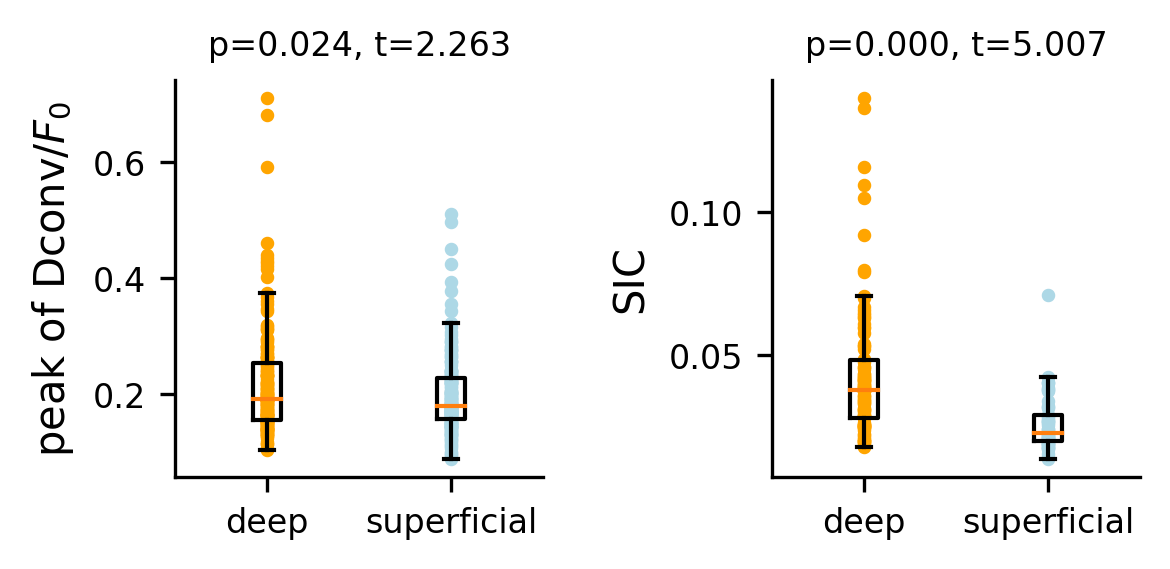

In [15]:
#load Potential_PC_results.pickle for both superficial and deep layer
with open(os.path.join(superficial_folder, 'UnrotTiff', '2D2P', 'Potential_PC_results.pickle'), 'rb') as f:
    Potential_PC_results_sf = pickle.load(f)
    
peaks_sf = Potential_PC_results_sf['decov_F_peaks']
peaks_sf = np.array(list(peaks_sf.values()))
SIC_real_all_sf = Potential_PC_results_sf['SIC_real_all']
SIC_real_all_sf = np.array(list(SIC_real_all_sf.values()))
PC_maps_sf = Potential_PC_results_sf['potentialPC_maps']

with open(os.path.join(deep_folder, 'UnrotTiff', '2D2P', 'Potential_PC_results.pickle'), 'rb') as f:
    Potential_PC_results_dp = pickle.load(f)

peaks_dp = Potential_PC_results_dp['decov_F_peaks']
peaks_dp = np.array(list(peaks_dp.values()))
SIC_real_all_dp = Potential_PC_results_dp['SIC_real_all']
SIC_real_all_dp = np.array(list(SIC_real_all_dp.values()))
PC_maps_dp = Potential_PC_results_dp['potentialPC_maps']

fig = plt.figure(figsize=(4,2), dpi=300)

#do a boxplot with scatters of the peaks
ax1 = fig.add_subplot(121)
ax1.boxplot([peaks_sf, peaks_dp], showfliers=False)
#add scatters
ax1.scatter(np.ones(len(peaks_sf)), peaks_sf, color='orange', s=5)
ax1.scatter(np.ones(len(peaks_dp))*2, peaks_dp, color='lightblue', s=5)

ax1.set_xticks([1, 2])
ax1.set_xticklabels(['deep', 'superficial'], fontsize=ticksize)
ax1.set_ylabel('peak of Dconv/$F_0$', fontsize=labelsize)
ax1.tick_params(axis='y', labelsize=ticksize)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

#test if the two distributions are significantly different using t test
#and add p and stat to the plot as a title, keep 3 digits after decimal point
from scipy import stats
t, p = stats.ttest_ind(peaks_sf, peaks_dp)
ax1.set_title('p={:.3f}, t={:.3f}'.format(p, t), fontsize=ticksize)
    
#do a boxplot with scatters of the SIC
ax2 = fig.add_subplot(122)
ax2.boxplot([SIC_real_all_sf, SIC_real_all_dp], showfliers=False)
#add scatters
ax2.scatter(np.ones(len(SIC_real_all_sf)), SIC_real_all_sf, color='orange', s=5)
ax2.scatter(np.ones(len(SIC_real_all_dp))*2, SIC_real_all_dp, color='lightblue', s=5)

ax2.set_xticks([1, 2])
ax2.set_xticklabels(['deep', 'superficial'], fontsize=ticksize)
ax2.set_ylabel('SIC', fontsize=labelsize)
ax2.tick_params(axis='y', labelsize=ticksize)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#test if the two distributions are significantly different using t test
#and add p and stat to the plot as a title, keep 3 digits after decimal point
from scipy import stats
t, p = stats.ttest_ind(SIC_real_all_sf, SIC_real_all_dp)
ax2.set_title('p={:.3f}, t={:.3f}'.format(p, t), fontsize=ticksize)

plt.tight_layout()

#save
savefolder = os.path.join(superficial_folder, 'UnrotTiff', '2D2P')
fig.savefig(os.path.join(savefolder, 'PC_comparison_peaks_and_SIC.png'), dpi=300)



### get correlation between first half and second half in superficial layer

In [16]:
processed_datafolder = os.path.join(superficial_folder, 'UnrotTiff/suite2p/plane0')
#load the processed data
spks = np.load(os.path.join(processed_datafolder, 'spks.npy'), allow_pickle=True)
ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
stats = np.load(os.path.join(processed_datafolder, 'stat.npy'), allow_pickle=True)
ops = ops.item()
iscell = np.load(os.path.join(processed_datafolder, 'iscell.npy'), allow_pickle=True)

#get the deltaF/F and firing rate from deconvolved calcium traces and neuropil corrected signal, if not exist, calculate it
if os.path.exists(os.path.join(processed_datafolder, 'deltaF.npy')) and os.path.exists(os.path.join(processed_datafolder, 'fr.npy')):
    deltaF = np.load(os.path.join(processed_datafolder, 'deltaF.npy'))
    fr = np.load(os.path.join(processed_datafolder, 'fr.npy'))
else:
    deltaF, fr = get_deltaF_F_and_fr(spks, Fcorr, moving_window=15, framerate=30, percetile=8)
    #save deltaF and fr to processed_datafolder as npy file
    np.save(os.path.join(processed_datafolder, 'deltaF.npy'), deltaF)
    np.save(os.path.join(processed_datafolder, 'fr.npy'), fr)

#for each neuron, calculate the tuning map
Corr_real_all_sf = []; Corr_real_all_cut_sf = []
half_time = timestamps_sf[len(timestamps_sf)//2]

for i, key in enumerate(PC_maps_sf.keys()):
    print('Calculating spatial information content of cell '+str(key))
    
    half1_fr_cells = fr[key][timestamps_sf<half_time]
    half1_Traj_x = Traj_x_sf[timestamps_sf<half_time]
    half1_Traj_z = Traj_z_sf[timestamps_sf<half_time]
    half1_timestamps = timestamps_sf[timestamps_sf<half_time]
    
    map1_real = getTuningMap(half1_fr_cells, half1_Traj_x, half1_Traj_z, half1_timestamps, VRsize=(1,1), 
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None) #set peak_thres to a large number to avoid plotting
    
    #second one plot the second half data
    half2_fr_cells = fr[key][timestamps_sf>=half_time]
    half2_Traj_x = Traj_x_sf[timestamps_sf>=half_time]
    half2_Traj_z = Traj_z_sf[timestamps_sf>=half_time]
    half2_timestamps = timestamps_sf[timestamps_sf>=half_time]
    map2_real = getTuningMap(half2_fr_cells, half2_Traj_x, half2_Traj_z, half2_timestamps, VRsize=(1,1), 
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None) #set peak_thres to a large number to avoid plotting
    
    #set nan values as o in both maps
    map1_real[np.isnan(map1_real)] = 0
    map2_real[np.isnan(map2_real)] = 0
    
    #calculate the correlation coefficient
    corr_real =  np.corrcoef(map1_real.flatten(), map2_real.flatten())[0,1]
    Corr_real_all_sf.append(corr_real)
    
    # cut the border for 5 pixels and keep teh remaining 30*30 pixels
    map1_real = map1_real[5:-5, 5:-5]
    map2_real = map2_real[5:-5, 5:-5]
    corr_real_cut =  np.corrcoef(map1_real.flatten(), map2_real.flatten())[0,1]
    Corr_real_all_cut_sf.append(corr_real_cut)
    

Calculating spatial information content of cell 1
Calculating spatial information content of cell 2
Calculating spatial information content of cell 3
Calculating spatial information content of cell 4
Calculating spatial information content of cell 5
Calculating spatial information content of cell 6
Calculating spatial information content of cell 7
Calculating spatial information content of cell 9
Calculating spatial information content of cell 11
Calculating spatial information content of cell 13
Calculating spatial information content of cell 15
Calculating spatial information content of cell 18
Calculating spatial information content of cell 20
Calculating spatial information content of cell 24
Calculating spatial information content of cell 31
Calculating spatial information content of cell 33
Calculating spatial information content of cell 38
Calculating spatial information content of cell 43
Calculating spatial information content of cell 44
Calculating spatial information content

### get correlation between first half and second half in deep layer

In [17]:
processed_datafolder = os.path.join(deep_folder, 'UnrotTiff/suite2p/plane0')
#load the processed data
spks = np.load(os.path.join(processed_datafolder, 'spks.npy'), allow_pickle=True)
ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
stats = np.load(os.path.join(processed_datafolder, 'stat.npy'), allow_pickle=True)
ops = ops.item()
iscell = np.load(os.path.join(processed_datafolder, 'iscell.npy'), allow_pickle=True)

#get the deltaF/F and firing rate from deconvolved calcium traces and neuropil corrected signal, if not exist, calculate it
if os.path.exists(os.path.join(processed_datafolder, 'deltaF.npy')) and os.path.exists(os.path.join(processed_datafolder, 'fr.npy')):
    deltaF = np.load(os.path.join(processed_datafolder, 'deltaF.npy'))
    fr = np.load(os.path.join(processed_datafolder, 'fr.npy'))
else:
    deltaF, fr = get_deltaF_F_and_fr(spks, Fcorr, moving_window=15, framerate=30, percetile=8)
    #save deltaF and fr to processed_datafolder as npy file
    np.save(os.path.join(processed_datafolder, 'deltaF.npy'), deltaF)
    np.save(os.path.join(processed_datafolder, 'fr.npy'), fr)

#for each neuron, calculate the tuning map
Corr_real_all_dp = []; Corr_real_all_cut_dp = []
half_time = timestamps_dp[len(timestamps_dp)//2]

for i, key in enumerate(PC_maps_dp.keys()):
    print('Calculating spatial information content of cell '+str(key))
    
    half1_fr_cells = fr[key][timestamps_dp<half_time]
    half1_Traj_x = Traj_x_dp[timestamps_dp<half_time]
    half1_Traj_z = Traj_z_dp[timestamps_dp<half_time]
    half1_timestamps = timestamps_dp[timestamps_dp<half_time]
    
    map1_real = getTuningMap(half1_fr_cells, half1_Traj_x, half1_Traj_z, half1_timestamps, VRsize=(1,1), 
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None) #set peak_thres to a large number to avoid plotting
    
    #second one plot the second half data
    half2_fr_cells = fr[key][timestamps_dp>=half_time]
    half2_Traj_x = Traj_x_dp[timestamps_dp>=half_time]
    half2_Traj_z = Traj_z_dp[timestamps_dp>=half_time]
    half2_timestamps = timestamps_dp[timestamps_dp>=half_time]
    map2_real = getTuningMap(half2_fr_cells, half2_Traj_x, half2_Traj_z, half2_timestamps, VRsize=(1,1), 
                        binsize=(0.025,0.025), sigma=3, speed_thres=0.025, boxcar_size=5, visit_thres=0.1,
                        peak_thres=1e8, cell_id = None, datafolder=None) #set peak_thres to a large number to avoid plotting
    
    #set nan values as o in both maps
    map1_real[np.isnan(map1_real)] = 0
    map2_real[np.isnan(map2_real)] = 0
    
    #calculate the correlation coefficient
    corr_real =  np.corrcoef(map1_real.flatten(), map2_real.flatten())[0,1]
    Corr_real_all_dp.append(corr_real)
    
    # cut the border for 5 pixels and keep teh remaining 30*30 pixels
    map1_real = map1_real[5:-5, 5:-5]
    map2_real = map2_real[5:-5, 5:-5]
    corr_real_cut =  np.corrcoef(map1_real.flatten(), map2_real.flatten())[0,1]
    Corr_real_all_cut_dp.append(corr_real_cut)
    

Calculating spatial information content of cell 0
Calculating spatial information content of cell 17
Calculating spatial information content of cell 31
Calculating spatial information content of cell 32
Calculating spatial information content of cell 56
Calculating spatial information content of cell 58
Calculating spatial information content of cell 68
Calculating spatial information content of cell 84
Calculating spatial information content of cell 88
Calculating spatial information content of cell 90
Calculating spatial information content of cell 101
Calculating spatial information content of cell 109
Calculating spatial information content of cell 111
Calculating spatial information content of cell 116
Calculating spatial information content of cell 133
Calculating spatial information content of cell 139
Calculating spatial information content of cell 149
Calculating spatial information content of cell 163
Calculating spatial information content of cell 167
Calculating spatial inf

### do stats and plot

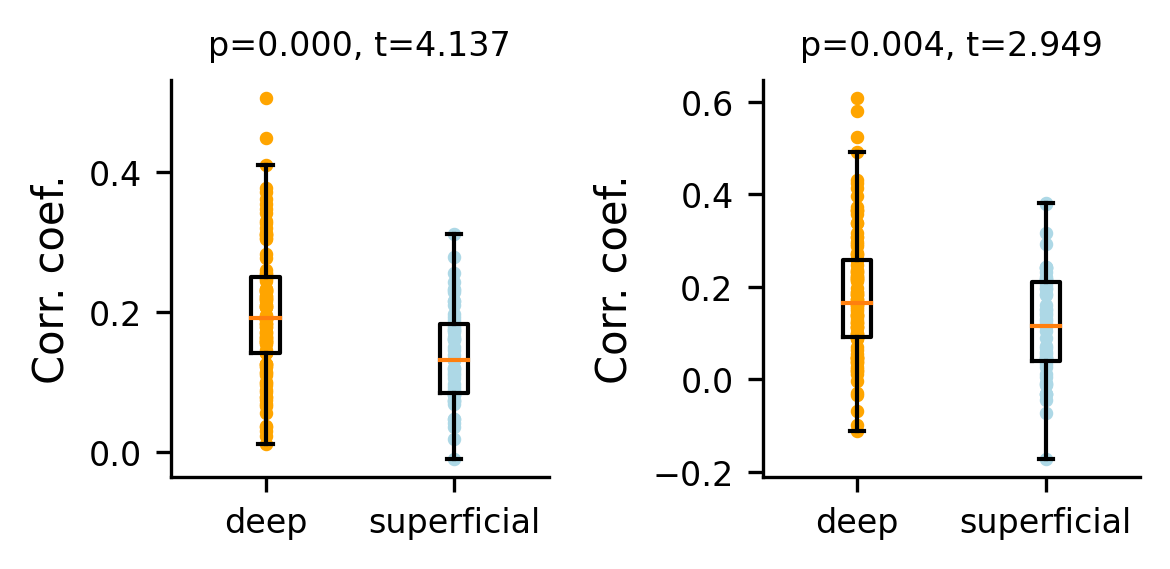

In [18]:
#do a boxplot with scatters
fig = plt.figure(figsize=(4,2), dpi=300)
ax = fig.add_subplot(121)
ax.boxplot([Corr_real_all_sf, Corr_real_all_dp], showfliers=False)
#add scatters
ax.scatter(np.ones(len(Corr_real_all_sf)), Corr_real_all_sf, color='orange', s=5)
ax.scatter(np.ones(len(Corr_real_all_dp))*2, Corr_real_all_dp, color='lightblue', s=5)

ax.set_xticks([1, 2])
ax.set_xticklabels(['deep', 'superficial'], fontsize=ticksize)
ax.set_ylabel('Corr. coef.', fontsize=labelsize)
ax.tick_params(axis='y', labelsize=ticksize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#test if the two distributions are significantly different using t test
#and add p and stat to the plot as a title, keep 3 digits after decimal point
from scipy import stats
t, p = stats.ttest_ind(Corr_real_all_sf, Corr_real_all_dp)
ax.set_title('p={:.3f}, t={:.3f}'.format(p, t), fontsize=ticksize)


##########################################################################################
#plot cutted corr
ax2 = fig.add_subplot(122)
ax2.boxplot([Corr_real_all_cut_sf, Corr_real_all_cut_dp], showfliers=False)
#add scatters
ax2.scatter(np.ones(len(Corr_real_all_cut_sf)), Corr_real_all_cut_sf, color='orange', s=5)
ax2.scatter(np.ones(len(Corr_real_all_cut_dp))*2, Corr_real_all_cut_dp, color='lightblue', s=5)

ax2.set_xticks([1, 2])
ax2.set_xticklabels(['deep', 'superficial'], fontsize=ticksize)
ax2.set_ylabel('Corr. coef.', fontsize=labelsize)
ax2.tick_params(axis='y', labelsize=ticksize)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#test if the two distributions are significantly different using t test
#and add p and stat to the plot as a title, keep 3 digits after decimal point
from scipy import stats
t, p = stats.ttest_ind(Corr_real_all_cut_sf, Corr_real_all_cut_dp)
ax2.set_title('p={:.3f}, t={:.3f}'.format(p, t), fontsize=ticksize)


plt.tight_layout()

#save
savefolder = os.path.join(superficial_folder, 'UnrotTiff', '2D2P')
fig.savefig(os.path.join(savefolder, 'PC_comparison_stability.png'), dpi=300)